In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [127]:
df = pd.read_csv(
    "../../Data/adult_income_sample.csv", delimiter=","
)

In [128]:
# Cleaning
df['sex_encoded'] = df['sex'].map({'Male': 1, 'Female': 0})
df['workclass_encoded'] = df['workclass'].map({'Private': 1, 'Gov': 0, 'Self-emp':2})
df['label_encoded'] = df['label'].map({'<=50K': 0, '>50K': 1})
df['education_encoded'] = df["education"].map({
    '11th': 0,
    'HS-grad': 1,
    'Some-college': 2,
    'Assoc': 3,
    'Bachelors': 4,
    'Masters': 5
})

In [129]:
# Scale all columns by 10 (except label and fnlwgt)
cols_to_scale = [col for col in df.columns if col not in ['label_encoded', 'fnlwgt']]
df[cols_to_scale] = df[cols_to_scale] * 10


In [130]:
# Create an interaction feature: workclass_encoded * education_encoded
df['workclass_education_interaction'] = df['workclass_encoded'] * df['education_encoded']
df = df.drop(columns=['workclass_encoded', 'education_encoded'])

In [131]:
# Create an interaction feature: age * sex_encoded
df['age_sex_interaction'] = df['age'] * df['sex_encoded']
df = df.drop(columns=['sex_encoded'])

                                      age    fnlwgt  hours_per_week  \
age                              1.000000 -0.024676        0.033341   
fnlwgt                          -0.024676  1.000000       -0.016498   
hours_per_week                   0.033341 -0.016498        1.000000   
label_encoded                    0.008057  0.024603        0.012421   
workclass_education_interaction  0.003067  0.032592       -0.041017   
age_sex_interaction              0.314465 -0.032790        0.051771   

                                 label_encoded  \
age                                   0.008057   
fnlwgt                                0.024603   
hours_per_week                        0.012421   
label_encoded                         1.000000   
workclass_education_interaction       0.019841   
age_sex_interaction                  -0.010328   

                                 workclass_education_interaction  \
age                                                     0.003067   
fnlwgt         

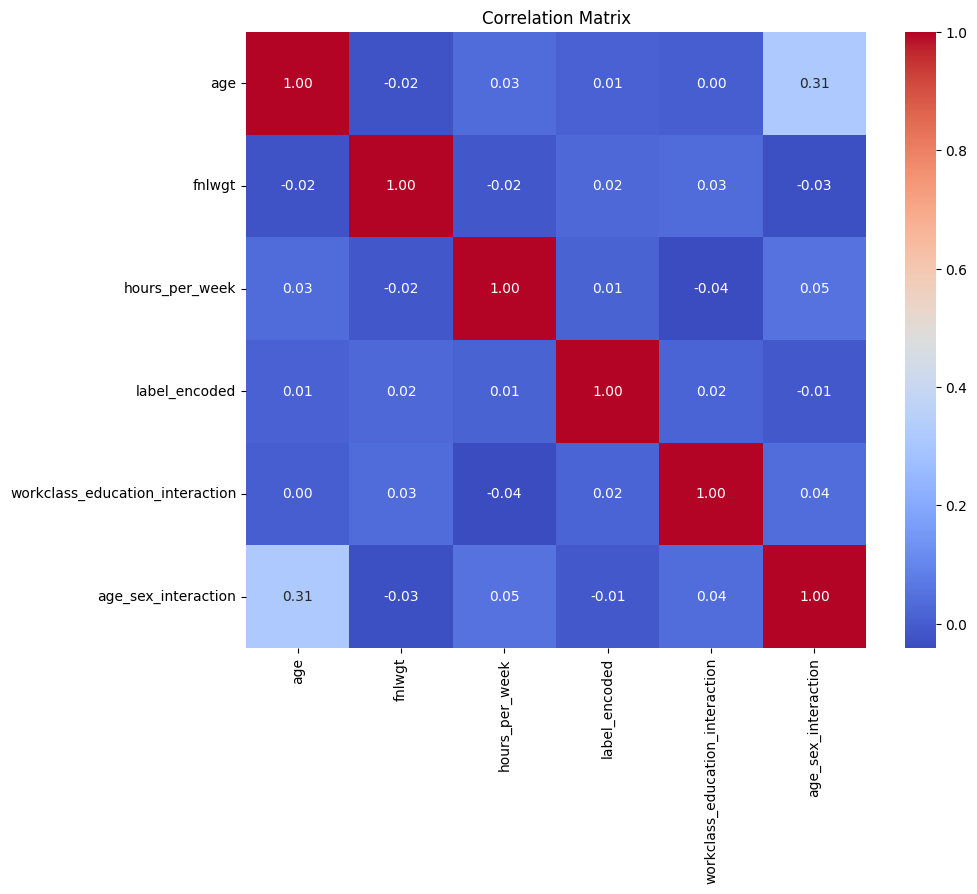

In [132]:
# Correlation matrix for numerical columns
df.dropna(inplace=True)


df = df.drop(columns=["sex", "workclass", "education", "label"])
corr_matrix = df.corr()
print(corr_matrix)
plt.figure(figsize=(10,8))
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [133]:
# List pairs of features with high correlation (>|0.8|)
threshold = 0.04
corr_matrix = df.corr().abs()
high_corr_pairs = []
for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i != j and corr_matrix.loc[i, j] > threshold:
            high_corr_pairs.append((i, j, corr_matrix.loc[i, j]))

if high_corr_pairs:
    print("Highly correlated feature pairs (>|0.08|):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} & {pair[1]}: {pair[2]:.2f}")
else:
    print("No highly correlated feature pairs found.")

Highly correlated feature pairs (>|0.08|):
age & age_sex_interaction: 0.31
hours_per_week & workclass_education_interaction: 0.04
hours_per_week & age_sex_interaction: 0.05
workclass_education_interaction & hours_per_week: 0.04
workclass_education_interaction & age_sex_interaction: 0.04
age_sex_interaction & age: 0.31
age_sex_interaction & hours_per_week: 0.05
age_sex_interaction & workclass_education_interaction: 0.04


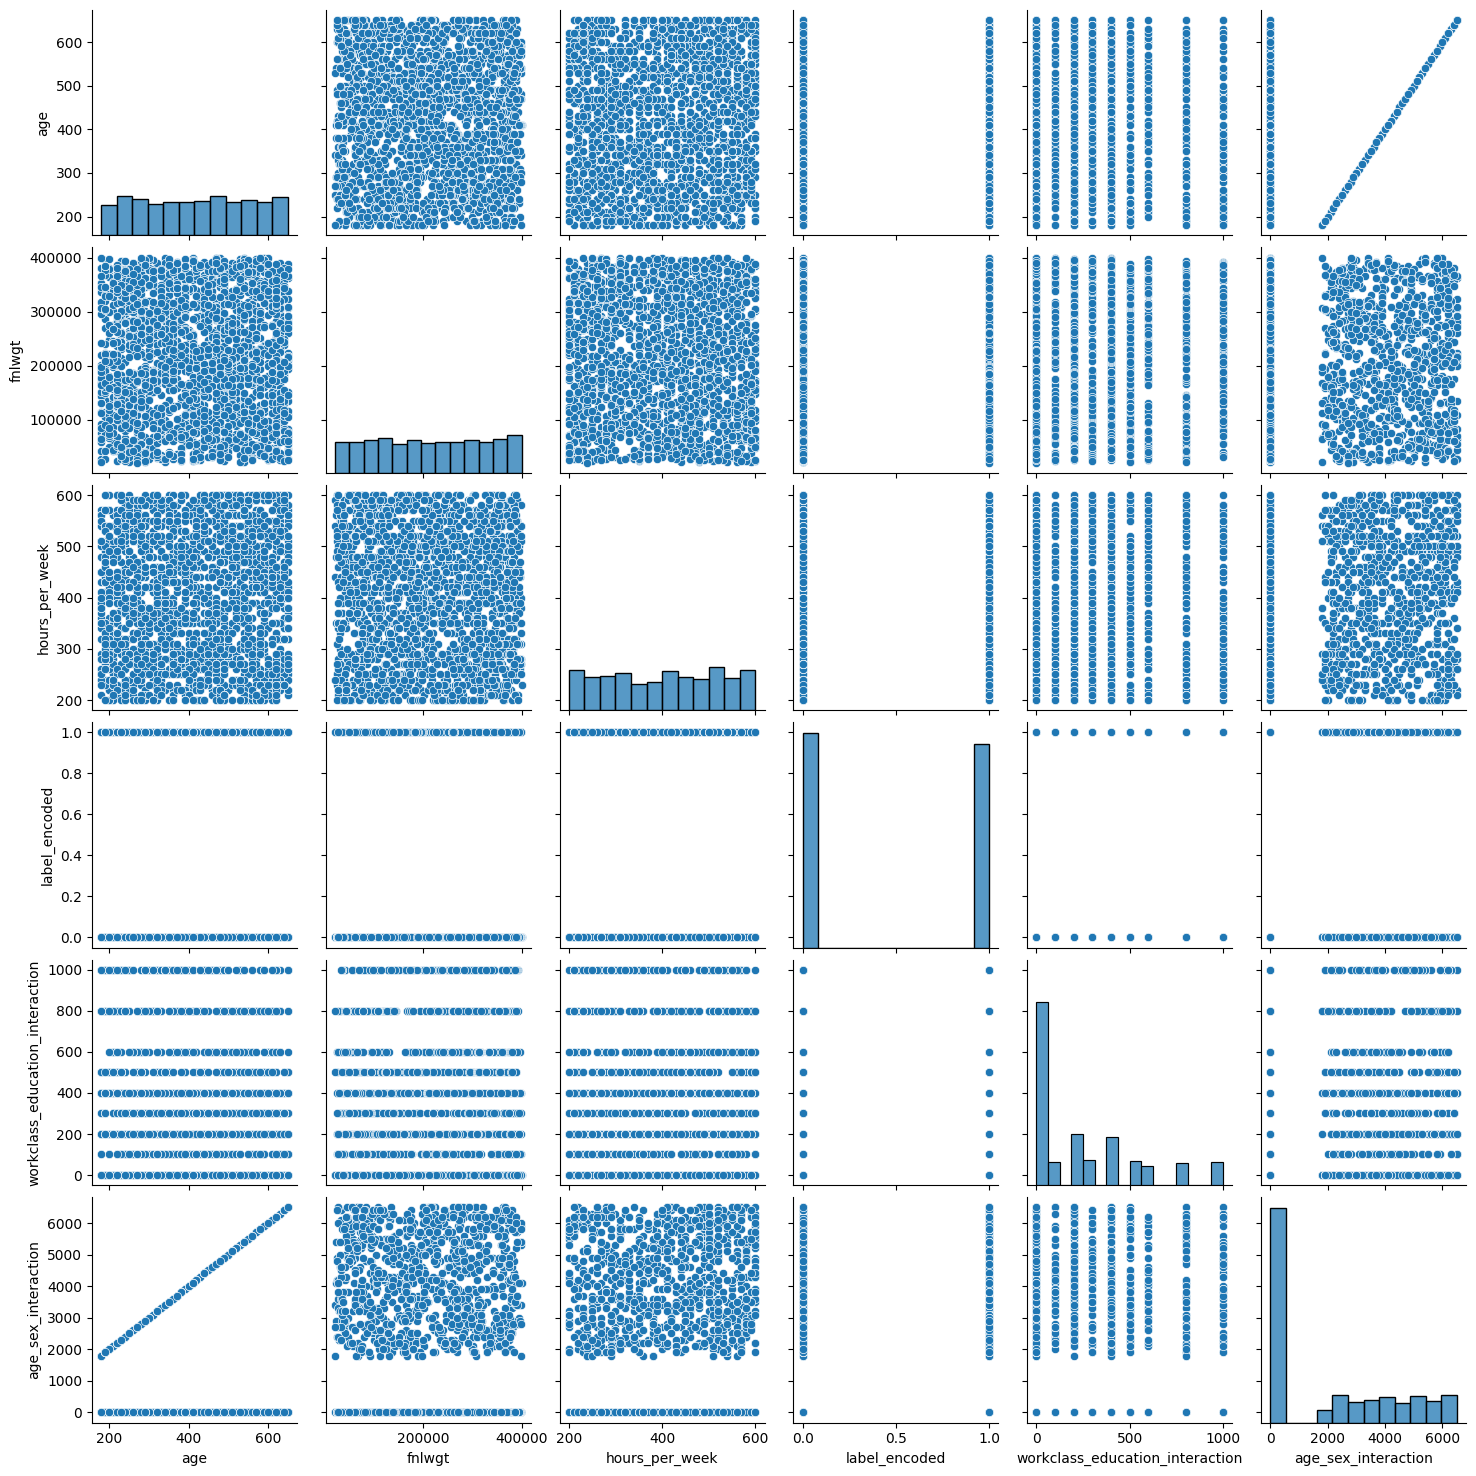

In [134]:
# Pairplot to visualize interactions between all features
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df)
plt.show()

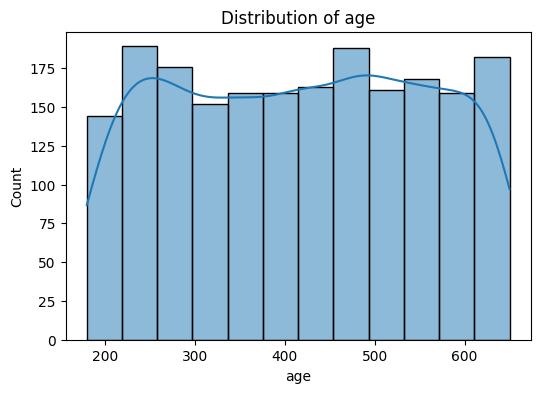

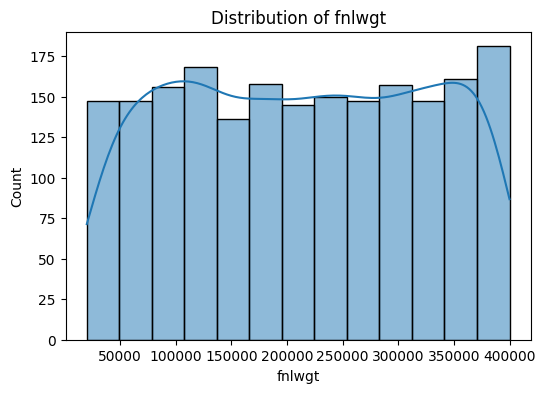

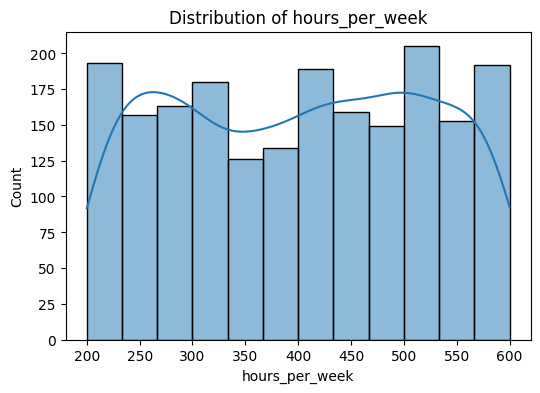

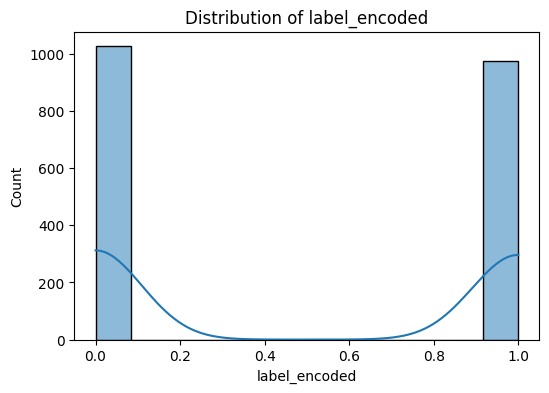

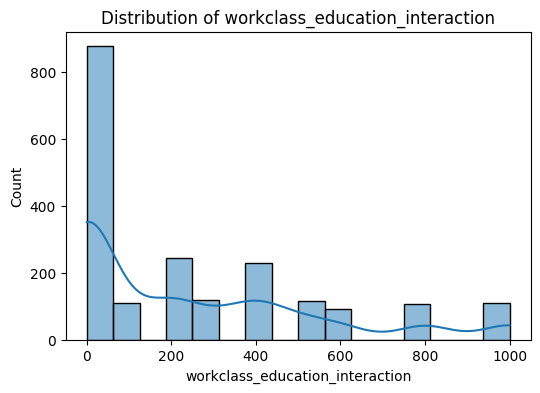

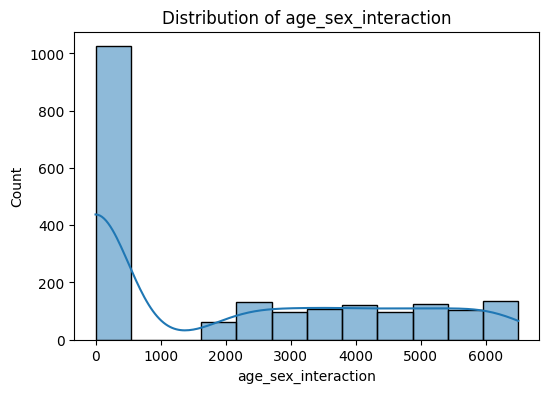

In [135]:
# Visualize distributions of all features
for col in df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [136]:
# Split the dataset: 10% test, 90% train+val (single split, good practice)
from sklearn.model_selection import train_test_split

X = df.drop(columns=['label_encoded', 'fnlwgt'])  # features
y = df['label_encoded']  # target
weights = df['fnlwgt']   # sample weights

# First split: 10% test, 90% train+val
X_trainval, X_test, y_trainval, y_test, weights_trainval, weights_test = train_test_split(
    X, y, weights, test_size=0.10, random_state=42
 )

# Second split: train/val from trainval (e.g., 20% train, 80% val from trainval)
X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
    X_trainval, y_trainval, weights_trainval, test_size=0.80, random_state=42
 )

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (360, 4), Validation shape: (1440, 4), Test shape: (200, 4)


In [137]:
# Train the logistic regression model using only the training set
model = LogisticRegression(class_weight='balanced', solver="liblinear")
model.fit(X_train, y_train, weights_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [138]:
# Cross-validation for logistic regression
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(
    LogisticRegression(class_weight='balanced', solver="liblinear"),
    X_trainval, y_trainval, cv=cv, scoring='accuracy'
 )

print(f"Cross-validation accuracy scores: {scores}")
print(f"Mean CV accuracy: {scores.mean():.4f}")

Cross-validation accuracy scores: [0.48888889 0.50555556 0.51111111 0.5        0.44444444 0.47222222
 0.47222222 0.51666667 0.49444444 0.53888889]
Mean CV accuracy: 0.4944


In [142]:
# Test SVM, KNN, and LightGBM classifiers
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

models = {
    'SVM': SVC(kernel='rbf', class_weight='balanced', random_state=42),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f'\n{name} Validation Results:')
    print('Accuracy:', accuracy_score(y_val, y_pred))
    print('Precision:', precision_score(y_val, y_pred))
    print('Recall:', recall_score(y_val, y_pred))
    print('F1 Score:', f1_score(y_val, y_pred))
    print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred))


SVM Validation Results:
Accuracy: 0.5194444444444445
Precision: 0.5
Recall: 0.3078034682080925
F1 Score: 0.3810375670840787
Confusion Matrix:
 [[535 213]
 [479 213]]
